In [1]:
import os
import numpy as np
import torchaudio
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import librosa
import librosa.display
from IPython.display import Audio, display  # For audio playback

In [2]:
Clean_Data_Directory = r"C:\Users\ashut\SelectiveNoiseReduction_MiniProject_SEM6\DataSet\clean_trainset_28spk_wav"
Noisy_Data_Directory = r"C:\Users\ashut\SelectiveNoiseReduction_MiniProject_SEM6\DataSet\noisy_trainset_28spk_wav"

In [4]:
#Load Audio Data Function
def load_data(Clean_Data_Directory, Noisy_Data_Directory, batch_size=16, max_samples=1000):
    clean_signals, noisy_signals = [], []

    # Load audio files
    clean_files = [f for f in os.listdir(Clean_Data_Directory) if f.endswith('.wav')][:max_samples]
    noisy_files = [f for f in os.listdir(Noisy_Data_Directory) if f.endswith('.wav')][:max_samples]

    for f in tqdm(clean_files, desc="Loading clean files"):
        waveform, _ = torchaudio.load(os.path.join(Clean_Data_Directory, f))
        clean_signals.append(waveform)

    for f in tqdm(noisy_files, desc="Loading noisy files"):
        waveform, _ = torchaudio.load(os.path.join(Noisy_Data_Directory, f))
        noisy_signals.append(waveform)

    # Ensure matching clean and noisy samples
    if len(clean_signals) != len(noisy_signals):
        raise ValueError(f"Mismatch: {len(clean_signals)} clean signals and {len(noisy_signals)} noisy signals.")
    
    # Pad or truncate signals to a common length
    min_length = min(max(s.shape[1] for s in clean_signals), max(s.shape[1] for s in noisy_signals))
    clean_signals_array = [clean[:, :min_length] if clean.shape[1] > min_length else torch.cat([clean, torch.zeros(1, min_length - clean.shape[1])], dim=1) for clean in clean_signals]
    noisy_signals_array = [noisy[:, :min_length] if noisy.shape[1] > min_length else torch.cat([noisy, torch.zeros(1, min_length - noisy.shape[1])], dim=1) for noisy in noisy_signals]

    clean_tensor = torch.stack(clean_signals_array)
    noisy_tensor = torch.stack(noisy_signals_array)
    dataset = TensorDataset(noisy_tensor, clean_tensor)

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
#Speech Enhancement Model
# Define model
class SpeechEnhancementModel(nn.Module):
    def __init__(self):
        super(SpeechEnhancementModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return x

In [7]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model and move it to GPU
model = SpeechEnhancementModel().to(device)

# Training function (updated for GPU support)
def train_model(model, dataloader, epochs=5, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_values = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0
        for noisy, clean in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move data to GPU
            noisy, clean = noisy.to(device), clean.to(device)
            
            optimizer.zero_grad()
            outputs = model(noisy)
            loss = criterion(outputs, clean)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        average_loss = epoch_loss / len(dataloader)
        loss_values.append(average_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}")

    return loss_values

# Load data
dataloader = load_data(Clean_Data_Directory, Noisy_Data_Directory, batch_size=8, max_samples=1000)

# Train the model
loss_values = train_model(model, dataloader, epochs=10)

# Save the trained model
torch.save(model.state_dict(), 'speech_enhancement_model_New.pth')
print("Model saved as 'speech_enhancement_model_New.pth'")


Using device: cuda


Epoch 1/10: 100%|██████████| 125/125 [00:10<00:00, 12.26it/s]


Epoch [1/10], Loss: 0.0005


Epoch 2/10: 100%|██████████| 125/125 [00:09<00:00, 13.61it/s]


Epoch [2/10], Loss: 0.0003


Epoch 3/10: 100%|██████████| 125/125 [00:09<00:00, 13.69it/s]


Epoch [3/10], Loss: 0.0002


Epoch 4/10: 100%|██████████| 125/125 [00:09<00:00, 13.61it/s]


Epoch [4/10], Loss: 0.0002


Epoch 5/10: 100%|██████████| 125/125 [00:09<00:00, 13.62it/s]


Epoch [5/10], Loss: 0.0002


Epoch 6/10: 100%|██████████| 125/125 [00:09<00:00, 13.61it/s]


Epoch [6/10], Loss: 0.0002


Epoch 7/10: 100%|██████████| 125/125 [00:09<00:00, 13.57it/s]


Epoch [7/10], Loss: 0.0002


Epoch 8/10: 100%|██████████| 125/125 [00:09<00:00, 13.56it/s]


Epoch [8/10], Loss: 0.0002


Epoch 9/10: 100%|██████████| 125/125 [00:09<00:00, 13.59it/s]


Epoch [9/10], Loss: 0.0002


Epoch 10/10: 100%|██████████| 125/125 [00:09<00:00, 13.56it/s]

Epoch [10/10], Loss: 0.0002
Model saved as 'speech_enhancement_model_New.pth'


In [8]:
# Evaluation metrics calculation
def calculate_metrics(original, enhanced):
    mse = torch.mean((original - enhanced) ** 2).item()
    rmse = np.sqrt(mse)
    psnr = 10 * np.log10(1 / mse) if mse != 0 else float('inf')
    snr = 10 * torch.log10(torch.mean(original ** 2) / torch.mean((original - enhanced) ** 2)).item()
    sdr = snr  # Similar to SNR for non-negative signals in dB

    return {"MSE": mse, "RMSE": rmse, "PSNR": psnr, "SNR": snr, "SDR": sdr}

In [9]:
# Spectrogram plotting
def plot_spectrogram(signal, title='Spectrogram', sr=22050):
    plt.figure(figsize=(10, 4))
    X = librosa.stft(signal.numpy())
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.title(title)
    plt.show()

In [12]:
# Testing with metrics and visualization
def test_model(model, audio_path):
    model.eval()  # Set the model to evaluation mode
    waveform, sr = torchaudio.load(audio_path)
    waveform = waveform.unsqueeze(0)  # Add batch dimension
    
    # Move waveform to the same device as the model
    waveform = waveform.to(device)
    
    with torch.no_grad():
        enhanced_signal = model(waveform)
    
    # Move enhanced_signal back to the CPU for playback and visualization
    enhanced_signal = enhanced_signal.cpu()

    # Original and Enhanced Audio playback
    print("Original Noisy Audio:")
    display(Audio(waveform.squeeze().cpu().numpy(), rate=sr))  # Move waveform to CPU for playback

    print("Enhanced Audio:")
    display(Audio(enhanced_signal.squeeze().numpy(), rate=sr))

    # Plot spectrograms for visual comparison
    plot_spectrogram(waveform.squeeze().cpu(), title="Original Noisy Signal Spectrogram")
    plot_spectrogram(enhanced_signal.squeeze(), title="Enhanced Signal Spectrogram")

    # Calculate and display metrics
    metrics = calculate_metrics(waveform.squeeze().cpu(), enhanced_signal.squeeze())
    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Save enhanced audio
    torchaudio.save('enhanced_output.wav', enhanced_signal.squeeze(0), sr)
    print("Enhanced audio saved as 'enhanced_output.wav'")


Original Noisy Audio:


Enhanced Audio:


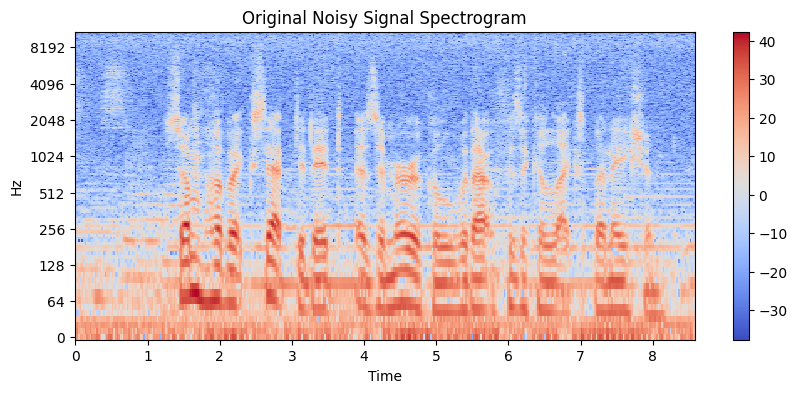

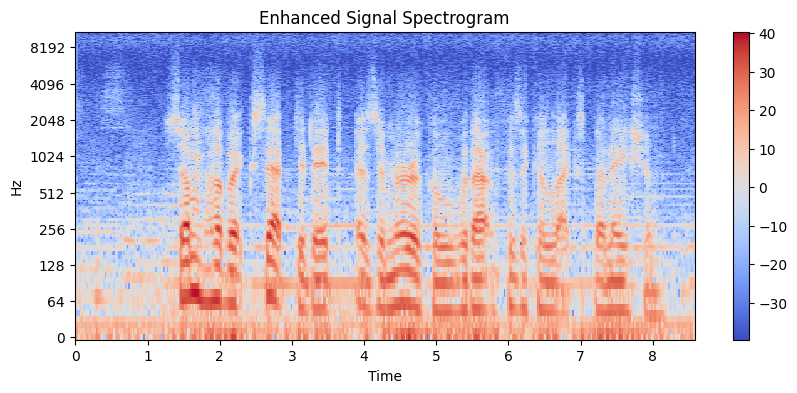


Evaluation Metrics:
MSE: 0.0009
RMSE: 0.0303
PSNR: 30.3838
SNR: 9.6162
SDR: 9.6162
Enhanced audio saved as 'enhanced_output.wav'


In [13]:
# Example usage
test_audio_path = r"C:\Users\ashut\SelectiveNoiseReduction_MiniProject_SEM6\DataSet\noisy_testset_wav\p232_013.wav"
test_model(model, test_audio_path)